<a href="https://colab.research.google.com/github/FoleyLab/wptherml/blob/master/example/Validate_Cooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Validation of Cooling Lib
This notebook will build the multi-layer structure described in Raman $et$ $al.$, Nature 515, 540-546 (2014), compute plot its emissivity in the solar region and in the atmospheric transmissivity region of the spectrum (~300-2500 nm for the former, 2500-20000 nm for the latter), and compute the cooling power for several different differences between the temperature of the structure and the ambient temperature.  

Two differences between this notebook and the structure described in Raman $et$ $al.$ to note: (1) in this example, we terminate the multilayer at the optically thick Ag layer; the full structure described by Raman $et$ $al.$ involved was grown on a silicon substrate and included a thin (10 nm) titanium adhesion layer. Due to the very small skin depth of silver in the visible and IR, these layers make virtually no contribution to the optical properties of the stack.  To confirm there is negligible transmission through the terminal silver layer, one can plot the transmissivity of the multilayer by uncommenting the indicated lines below to confirm no visible or IR light is transmissited through the stack. (2) The refractive index data for materials described by Raman $et$ $al.$ are determined by ellipsometry on as-fabricated materials, and likely differ from the refractive index data employed by WPTherml.  For more information on the refractive index data employed by WPTherml, see https://github.com/FoleyLab/wptherml/blob/master/wptherml/datalib/REFERENCES.md.




In [ ]:
!pip install wptherml

  Gradient will be taken with respect to all layers! 
 Temperature not specified!
 Proceeding with default T = 300 K


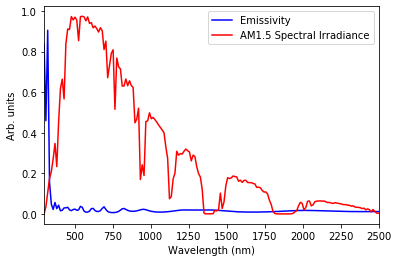

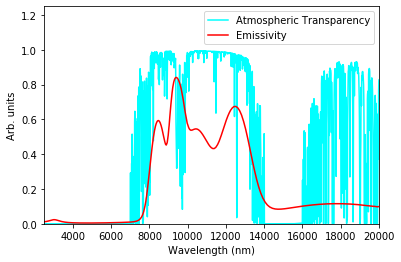

In [1]:
### Import WPTHERML class!
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from wptherml.datalib import datalib

### Define structure!
structure = {

        'Material_List': ['Air', 'SiO2', 'HfO2', 'SiO2', 'HfO2', 'SiO2', 'HfO2', 'SiO2', 'Ag', 'Air'],
        'Thickness_List': [0, 230e-9, 485e-9, 688e-9, 13e-9, 73e-9, 34e-9, 54e-9, 200e-9, 0],
        'Lambda_List': [300e-9, 60000e-9, 5000],
        'EXPLICIT_ANGLE': 1,
        'COOLING': 1
     
        }

### create instance of multilayer class called cool_ml
cool_ml = multilayer(structure)

### get AM1.5 spectra and atmospheric transmissivity data from datalib
AM = datalib.AM(cool_ml.lambda_array)
T_atm = datalib.ATData(cool_ml.lambda_array)

### plot emissivity of cool_ml against AM1.5 spectrum in the visible range
### to demonstrate the high solar reflectivity of cool_ml
plt.plot(cool_ml.lambda_array*1e9, cool_ml.emissivity_array, 'blue', label='Emissivity')
plt.plot(cool_ml.lambda_array*1e9, AM/(1.4*1e9), 'red', label='AM1.5 Spectral Irradiance')
### Uncomment the next line if you want to plot the transmissivity of the multilayer in the visible
#plt.plot(cool_ml.lambda_array*1e9, cool_ml.transmissivity_array, 'green', label='Transmissivity')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Arb. units")
plt.legend(loc = 'best')
plt.xlim(300,2500)
plt.show()

### plot the emissivity of cool_ml against the atmospheric transmissivity in the IR
### to demonstrate the selective thermal emissivity of cool_ml
plt.plot(cool_ml.lambda_array*1e9, T_atm, 'cyan', label='Atmospheric Transparency')
plt.plot(cool_ml.lambda_array*1e9, cool_ml.emissivity_array, 'red', label='Emissivity')
### Uncomment the next line if you want to plot the transmissivity of
### the multilayer in the IR
#plt.plot(cool_ml.lambda_array*1e9, cool_ml.transmissivity_array, 'green', label='Transmissivity')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Arb. units")
plt.legend(loc = 'best')
plt.xlim(2500,20000)
plt.ylim(0,1.25)
plt.show()


### Validate Power Radiated Against Stefan-Boltzmann law
Here we will force the cool_ml structure to be a perfect absorber/emitter across the visible and IR using the method *step_emissivity_ea(central_lambda, delta_lambda)* and then re-calling
the *cooling_power()* method, which will numerically integrate the thermal emission of cool_ml  over wavelength and angle at 300 K.  This shoudl in principle be the same as integrating a blackbody at 300 K, so should agree with the Stefan-Boltzmann law.  In practice, there will be numerical error from truncation of the wavelength range of cool_ml, and of finite sampling of angles of emission.

In [2]:

### now make structure a blackbody emitter at all angles
cool_ml.step_emissivity_ea(20000e-9,80000e-9)
### This is only normal emissivity in case you want to plot it!
cool_ml.step_emissivity(20000e-9,80000e-9)
### re-compute thermal emission spectra at each angle
cool_ml.thermal_emission_ea()
### re-compute cooling power
cool_ml.cooling_power()




sig = 5.670367e-8
### plot results assuming blackbody emissivity
print("Radiative Power (cooling) is ",cool_ml.radiative_power_val, "W/m^2")
print("Stefan-Boltzmann Law is ",cool_ml.T_ml**4*sig, "W/m^2")

Radiative Power (cooling) is  450.4891874450116 W/m^2
Stefan-Boltzmann Law is  459.29972699999996 W/m^2


The two results agree to 2 significant figures, which is reasonable considering the errors mentioned above, is reasonable to validate that our angular and wavelength integration performed within the cooling_power() method is functioning.  The accuracy could be systematically improved by (1) increasing the wavelength range of integration by decreasing (increasing) the minimum (maximum) wavelengths in Lambda_List, (2) increasing the wavelength resolution by increasing the number of wavelengths in Lambda_List, and (3) increasing the angular resolution by increasing the number of angles in the angular integrals using 'DEG' keyword in the structure dictionary.  For example, the entry 
'DEG': 10 would perform the angular integrals over 10 different angles rather than the default 7.  Increasing the wavelength and angular resolution will increase the computation time.

We can also re-plot the quantities as before to visualize how the step_emissivity() method modifies the emissivity of cool_ml.

In [ ]:
### get AM1.5 spectra and transmissivity data
AM = datalib.AM(cool_ml.lambda_array)
T_atm = datalib.ATData(cool_ml.lambda_array)
### plot results of perfect emissivity!
plt.plot(cool_ml.lambda_array*1e6, cool_ml.emissivity_array, 'blue', label='Emissivity')
plt.plot(cool_ml.lambda_array*1e6, AM/(1.4*1e9), 'red', label='AM1.5 Spectral Irradiance')
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("(arb. units)")
plt.xlim(0.3,2.5)
plt.legend()
plt.show()


plt.plot(cool_ml.lambda_array*1e6, T_atm, 'cyan', label='Atmospheric Transparency')
plt.plot(cool_ml.lambda_array*1e6, cool_ml.emissivity_array, 'red', label='Emissivity')
#plt.plot(w_slab.lambda_array*1e6, BB, 'black')
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("(arb. units)")
plt.xlim(2.5,60)
plt.legend()
plt.show()